In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from multiprocessing.pool import ThreadPool

Note: When doing CV and standardizing, don't include testing data when calculating mean and sd since that causes the testing data to influence the training data. Just take mean and sd of training and standardize both training and testing using those. 


## 2.1 Homework

### Problem 1

In [2]:
def load_data():
    df = pd.read_csv('boston.csv')
    X = df.drop(['ZN','CHAS','MEDV'],axis=1)
    Y = np.log10(df['MEDV'])
    return X,Y

def calc_ahat(X,Y,n,j,betas):
    prod = (Y - sum(X.drop(X.columns[j], axis=1) @ np.delete(betas,j)))
    a_hat = (1/n) * sum(X.iloc[:,j] * prod)
    return a_hat
    
def calc_betaj(X,Y,n,j,betas,lambda_):
    a_hat = calc_ahat(X,Y,n,j,betas)
    sign = np.sign(a_hat)
    max_right = max(np.abs(a_hat) - (n/2)*lambda_,0)
    beta_hat_j = sign * max_right
    return beta_hat_j

def lasso(X,Y,lambda_,epsilon=1e-6):
    n = X.shape[0]
    p = X.shape[1]
    betas = np.random.normal(size=p)
    err = 1
    while err > epsilon:
        last_beta = betas.copy()
        for j in np.arange(p):
            betas[j] = calc_betaj(X,Y,n,j,betas,lambda_)
        err = np.sum(np.abs(betas-last_beta))
    return betas

def normalize(df):
    return (df - df.mean())/df.std()
    
def train_test_split(X,Y,folds,i):
    temp = folds[:]
    testing_idx = temp.pop(i)
    training_idx = np.concatenate(temp)
    X_train, X_test, Y_train, Y_test = X.iloc[training_idx,:], X.iloc[testing_idx,:], Y.iloc[training_idx,], Y.iloc[testing_idx,]
    X_train = normalize(X_train)
    X_train['const'] = 1
    X_test = normalize(X_test)
    X_test['const'] = 1
    return X_train, X_test, Y_train, Y_test

def sse(predicted,actual):
    return sum((predicted - actual) ** 2)

def cv(lambda_,k=5):
    X,Y = load_data()
    n = X.shape[0]
    # creating indices for folds
    folds = []
    remaining_idx = np.arange(n)
    for i in np.arange(k):
        indices = np.random.choice(remaining_idx,round(n * 1/k), replace=False)
        remaining_idx = np.setdiff1d(remaining_idx, indices)
        folds.append(indices)
        
    # calculating total error
    total_error = 0
    for i,_ in enumerate(folds):
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y,folds,i)
        betas = lasso(X_train,Y_train,lambda_)
        predicted = X_test @ betas
        error = sse(predicted,Y_test)
        total_error += error
    return (betas, lambda_, total_error)

In [24]:
#%%timeit

lambdas = np.linspace(0,1e-3,1000)
with ThreadPool(3) as pool:
    output = pool.map(cv,lambdas)

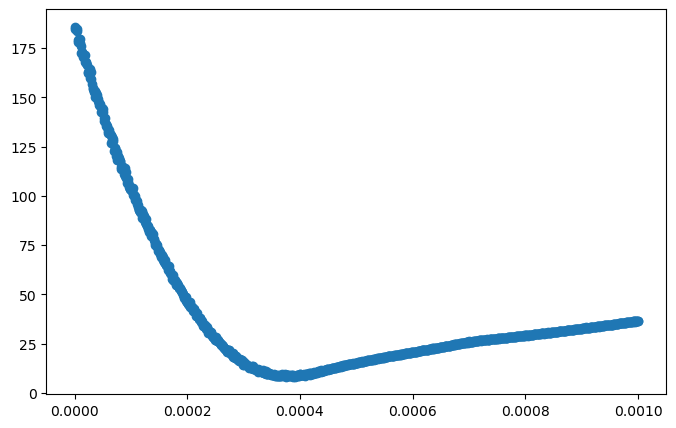

In [28]:
betas = []
lambdas = []
errors = []

for b,l,err in output:
    betas.append(b)
    lambdas.append(l)
    errors.append(err)
    
plt.figure(figsize=[8,5])
plt.scatter(x = lambdas, y = errors)

In [35]:
prob_1_results = pd.DataFrame({'Betas':betas,'Lambda':lambdas,'Errors':errors}).sort_values(by='Errors')

In [42]:
prob_1_results['Betas'].values[0]

array([-0.01845892, -0.01704675, -0.01384464,  0.03383996, -0.00222605,
        0.        , -0.00651573, -0.02063073, -0.00779799,  0.        ,
       -0.06637625,  1.23639329])

In [43]:
prob_1_results['Lambda'].values[0]

0.00039139139139139135

In [44]:
prob_1_results['Errors'].values[0]

8.130190897447271

In [111]:
X,Y = load_data()

In [113]:
X

,CRIM,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,2.31,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,7.07,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,7.07,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,2.18,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,2.18,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,11.93,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67
502,0.04527,11.93,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08
503,0.06076,11.93,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64
504,0.10959,11.93,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48


In [112]:
X.iloc[:,[1,3,4]]

,INDUS,RM,AGE
0,2.31,6.575,65.2
1,7.07,6.421,78.9
2,7.07,7.185,61.1
3,2.18,6.998,45.8
4,2.18,7.147,54.2
...,...,...,...
501,11.93,6.593,69.1
502,11.93,6.120,76.7
503,11.93,6.976,91.0
504,11.93,6.794,89.3


### Problem 2

#### Part (a)

In [ ]:
df = 

### Part (b)

In [97]:
W = np.random.rand(200,50)
D = np.random.rand(1,200).reshape(-1,1)
Y = D * 3 + np.random.normal(size=200)
X = np.concatenate((D,W),axis=1)

In [99]:
from sklearn.linear_model import LinearRegression, LassoCV
import cvxpy as c

In [104]:
def OLS(X,Y):
    ols = LinearRegression()
    ols.fit(X,Y)
    beta_1 = ols.coef_.flatten()[0]
    return beta_1

def Lasso(X,Y):
    lasso = LassoCV()
    lasso.fit(X,Y)
    beta_1 = lasso.coef_.flatten()[0]
    return beta_1

def Dantzig(D,W,Y):
    pass

def Post(X,Y):
    # variable selection
    lasso = LassoCV()
    lasso.fit(X,Y)
    var_select = [i for i, coef in enumerate(lasso.coef_.flatten()) if coef != 0]
    X_select = X.iloc[:,var_select]
    
    # OLS
    return OLS(X_select,Y)
    

def Double(D,W,Y):
    X = np.concatenate((D,W),axis=1)
    
    # obtain gamma
    gamma = Lasso(W,D)
    
    # beta1, beta2
    lasso = LassoCV()
    lasso.fit(X,Y)
    beta_1 = lasso.coef_.flatten()[0]
    beta_2 = lasso.coef_.flatten()[1:]
    
    # estimation
    n = X.shape[0]
    num = (1/n) * (np.sum((Y - W @ beta_2) * (D - W @ gamma)))
    denom = (1/n) * (np.sum(D * (D - W @ gamma)))
    beta_DL = num / denom
    return beta_DL

IndentationError: expected an indented block (3877583650.py, line 8)

In [105]:
temp = np.random.randint(0,5,size=100)

In [109]:
temp

array([1, 4, 1, 0, 1, 3, 1, 2, 1, 1, 0, 3, 2, 2, 1, 4, 4, 1, 0, 2, 2, 3,
       1, 3, 4, 4, 3, 4, 2, 3, 4, 1, 0, 3, 1, 4, 4, 3, 2, 4, 4, 3, 0, 4,
       1, 2, 3, 4, 2, 1, 2, 4, 0, 1, 4, 2, 4, 2, 2, 0, 0, 4, 0, 1, 4, 0,
       4, 4, 2, 3, 2, 4, 0, 4, 3, 3, 0, 1, 3, 1, 2, 0, 4, 0, 0, 0, 0, 3,
       0, 0, 1, 4, 4, 1, 2, 0, 3, 0, 0, 2])

In [108]:
np.where(temp != 0, 1, 0)

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1])

### Part (c)